In [1]:
!pwd

/home/studio-lab-user/Blackbox-Coresets-VI/psvi/notebooks


In [2]:
%load_ext autoreload
%autoreload 2


In [3]:
import os 
import sys
sys.path.append("/home/studio-lab-user/Blackbox-Coresets-VI")

In [4]:
method_args = {
    'data_folder': '/home/studio-lab-user/all_data/vi_data',
    'test_ratio': 0.2
}

In [5]:
from psvi.experiments.experiments_utils import read_dataset
from psvi.models.frequentist_models import FreqLogReg, FreqOneLayer
from torch.utils.data import DataLoader
from psvi.models.frequentist_models import RunFrequentistModel
from psvi.inference.baselines import run_el2n_coreset


import torch
import torch.optim as optim
import torch.distributions as dist
import torch.nn.functional as F

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt 
import numpy as np
import json

## Develop EL2N

In [73]:
x, y, xt, yt, N, D, \
train_dataset, test_dataset, num_classes = read_dataset("webspam", method_args)

X is either low-dimensional or not very sparse, so converting to a numpy array
X is either low-dimensional or not very sparse, so converting to a numpy array


In [74]:
from sklearn.cluster import KMeans

In [84]:
label_index = np.where(y.numpy() == 1)[0]

In [87]:
label_index[0:10]

array([ 2,  3,  4,  6,  7,  9, 10, 11, 12, 14])

In [75]:
kmeans = KMeans(n_clusters=40, random_state=0, n_init="auto").fit(x.numpy())

In [88]:
kmeans.labels_.shape

(126185,)

In [77]:
np.unique(kmeans.labels_)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39], dtype=int32)

In [90]:
kmeans.inertia_

21877.91015625

In [91]:
from collections import defaultdict
A = defaultdict(list)
for index, label in enumerate(kmeans.labels_):
    A[label].append(index)

In [7]:
train_dataset

In [9]:
#criterion = torch.nn.CrossEntropyLoss()
criterion = torch.nn.BCEWithLogitsLoss()
model = FreqLogReg(input_dim=D, num_classes=num_classes)
optimizer = optim.SGD(model.parameters(), lr=1e-3)


In [10]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [11]:
# train an epoch
for batch_idx, (data, target) in enumerate(train_dataloader):
    #if args['cuda']:
        #data, target = data.cuda(), target.cuda()
    #Variables in Pytorch are differenciable. 
    #data, target = Variable(data), Variable(target)
    #This will zero out the gradients for this batch. 
    optimizer.zero_grad()
    output = model(data)
    # Calculate the loss The negative log likelihood loss. It is useful to train a classification problem with C classes.
    loss = criterion(output.squeeze(), target)
    #dloss/dx for every Variable 
    loss.backward()
    #to do a one-step update on our parameter.
    optimizer.step()


In [34]:
target.long()

tensor([1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0,
        1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1])

In [14]:
output.size()

torch.Size([41, 2])

In [15]:
target.size()

torch.Size([41])

In [34]:
softmax_fn = torch.nn.Softmax()
sigmoid_fn = torch.nn.Sigmoid()
#outputs_prob = softmax_fn(output.squeeze())
#outputs_prob

In [38]:
softmax_fn(torch.tensor(-300.0))
sigmoid_fn(torch.tensor(1))

/tmp/ipykernel_126/2327056272.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax_fn(torch.tensor(-300.0))


tensor(0.7311)

In [32]:
outputs_prob.unsqueeze(1).size()

torch.Size([41, 1])

In [23]:
outputs_prob_0 = 1. - outputs_prob

In [33]:
torch.hstack((outputs_prob.unsqueeze(1), outputs_prob_0.unsqueeze(1))).size()

torch.Size([41, 2])

In [27]:
_, predicted = torch.max(output.data, 1)

In [29]:
(predicted == target.long()).sum().item()

26

In [18]:
output.squeeze().gt(0.5).float().eq(target).sum()

tensor(24)

In [20]:
dist.Bernoulli(probs=outputs_prob).log_prob(target).sum()

tensor(-92.8361, grad_fn=<SumBackward0>)

In [55]:
target.size(0)

41

In [10]:
criterion(output, torch.tensor(1))

ValueError: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])) is deprecated. Please ensure they have the same size.

In [19]:
torch.tensor(1).unsqueeze(0).size()

torch.Size([1])

In [37]:
#F.one_hot(target.long(), num_classes=2)


In [16]:
x, y, xt, yt, N, D, \
train_dataset, test_dataset, num_classes = read_dataset("webspam", method_args)


X is either low-dimensional or not very sparse, so converting to a numpy array
X is either low-dimensional or not very sparse, so converting to a numpy array


In [7]:
len(train_dataset)

126185

In [23]:
model = FreqLogReg(input_dim=D, num_classes=num_classes)

In [39]:
run_freq = RunFrequentistModel(
    train_dataset=train_dataset, test_dataset=test_dataset, model=model, 
    is_logreg=True, num_epochs=20
)

run_freq.train()

Epoch: 0
Accuracy: 0.7437289357185364, NLL: 0.5029181241989136
Epoch: 10
Accuracy: 0.7688131928443909, NLL: 0.481990247964859


In [40]:
#for param in model.parameters():
#  print(param.data)


In [41]:
el2n_scores = run_freq.get_el2n_scores()

In [42]:
run_freq.get_largest_el2n_indices(10)

[46691, 519, 82201, 119540, 16419, 72864, 116814, 84964, 98355, 51911]

In [43]:
el2n_scores[0:20]

tensor([0.8149, 0.8843, 0.5626, 0.2827, 0.4713, 0.3625, 0.2463, 0.2712, 0.5595,
        0.3034, 0.3195, 0.2402, 0.2956, 0.8847, 0.3406, 0.4722, 0.5980, 0.3927,
        0.1587, 0.3212])

In [7]:
run_el2n_coreset(
    x=x,
    y=y,
    xt=xt,
    yt=yt,
    mc_samples=4,
    num_epochs=30,
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    log_every=10,
    N=N,
    D=D,
    seed=0,
    mcmc=False,
    lr0net=1e-3,  # initial learning rate for optimizer
    nc=num_classes,
    data_minibatch=128,
) 

Epoch: 0
Accuracy: 0.6068795919418335, NLL: 0.6582239866256714
Epoch: 10
Accuracy: 0.641906201839447, NLL: 0.5972860455513


  3%|▎         | 1/30 [00:03<01:33,  3.22s/it]

predictive accuracy: 60.70%


 37%|███▋      | 11/30 [00:06<00:10,  1.85it/s]

predictive accuracy: 60.67%


100%|██████████| 30/30 [00:09<00:00,  3.03it/s]

predictive accuracy: 35.96%


{'accs': [0.6069939136505127, 0.6066510677337646, 0.3595794439315796],
 'nlls': [0.7019806504249573, 0.8734530806541443, 1.7704914808273315],
 'csizes': [0, 10, 20],
 'times': [],
 'wt_index': [{},
  {41186: 12618.5,
   119540: 12618.5,
   72864: 12618.5,
   1534: 12618.5,
   98355: 12618.5,
   60817: 12618.5,
   46691: 12618.5,
   119029: 12618.5,
   45438: 12618.5,
   63387: 12618.5},
  {41186: 6309.25,
   119540: 6309.25,
   72864: 6309.25,
   1534: 6309.25,
   98355: 6309.25,
   60817: 6309.25,
   46691: 6309.25,
   119029: 6309.25,
   45438: 6309.25,
   63387: 6309.25,
   18205: 6309.25,
   118535: 6309.25,
   58446: 6309.25,
   50390: 6309.25,
   107960: 6309.25,
   99605: 6309.25,
   8913: 6309.25,
   96515: 6309.25,
   43456: 6309.25,
   87349: 6309.25}]}

## Visualize Data

In [7]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt 
import numpy as np
import json

In [10]:
 x, y, xt, yt, N, D, \
train_dataset, test_dataset, num_classes = read_dataset("webspam", method_args)

X is either low-dimensional or not very sparse, so converting to a numpy array
X is either low-dimensional or not very sparse, so converting to a numpy array


In [95]:
x.shape

torch.Size([126185, 128])

In [11]:
def get_chosen_indices(iter_num):
    algo_name = 'kmeans'
    #algo_name = 'sparsevi'
    
    results_folder = "/home/studio-lab-user/all_data/vi_result"
    this_result_folder = f"{algo_name}_webspam"
    results_file = 'results.json'
    full_fname = os.path.join(results_folder, this_result_folder, results_file)
    with open(full_fname, 'r') as f:
        results = json.load(f)

    wt_index = results['webspam'][algo_name]['-1']['0'] ['wt_index']
    chosen_index = [int(x) for x in wt_index[iter_num].keys()]
    return chosen_index

    

In [12]:
iter_num = 3
index_small = list(np.random.randint(low=0, high=x.shape[0], size=5000))
algo_index = get_chosen_indices(iter_num)
num_pts = len(algo_index)
index_small = algo_index + index_small 

x_small = x[index_small,:]
y_small = y[index_small]

In [13]:
#x_small = x
#y_small = y

In [14]:
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(x_small)


In [15]:
X_embedded.shape

(5030, 2)

In [16]:
COLORS = ["red", "blue"]
color_list = [COLORS[x] for x in y_small.int().numpy()]

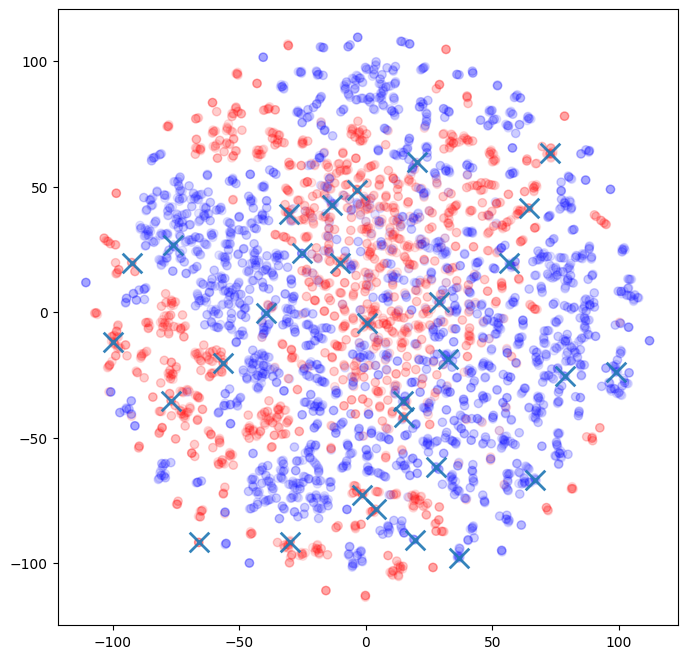

In [17]:
f, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(
    X_embedded[:,0],
    X_embedded[:,1],
    c=color_list, 
    alpha = 0.1
)

ax.scatter(X_embedded[0:num_pts,0], X_embedded[0:num_pts,1], marker="x", s=200, alpha=0.9, linewidth=2)

In [72]:
num_pts

18

In [16]:
results_folder = "/home/studio-lab-user/all_data/vi_result"
this_result_folder = "sparsevi_webspam"
results_file = 'results.json'
full_fname = os.path.join(results_folder, this_result_folder, results_file)
with open(full_fname, 'r') as f:
    results = json.load(f)


In [18]:
wt_index = results['webspam']['sparsevi']['-1']['0'] ['wt_index']

In [22]:
wt_index[1]
iter_num = 1
chosen_index = [int(x) for x in wt_index[iter_num].keys()]
chosen_x = x[chosen_index, :]
chosen_y = y[chosen_index]


In [23]:
ax.scatter(chosen_x, chosen_y)

ValueError: x and y must be the same size

In [65]:
results

{'webspam': {'sparsevi': {'-1': {'0': {'nlls': [0.706832230091095,
      0.5979381799697876,
      0.5229895114898682,
      0.4910760819911957,
      0.47776973247528076],
     'accs': [0.3931203782558441,
      0.6655048131942749,
      0.7785840630531311,
      0.7788126468658447,
      0.7742414474487305],
     'csizes': [0, 10, 16, 18, 19],
     'times': [1.5961334705352783,
      1430.1662843227386,
      4323.336601734161,
      8672.048276424408,
      14480.253889083862],
     'wt_index': [{},
      {'80186': 3.045764923095703,
       '55675': 2.7803032398223877,
       '80233': 2.445603609085083,
       '43805': 2.174753427505493,
       '83589': 1.957448124885559,
       '76071': 1.5967777967453003,
       '52108': 1.243882656097412,
       '77304': 1.0452356338500977,
       '65408': 0.6918947696685791,
       '71966': 0.3076845407485962},
      {'80186': 6.663400650024414,
       '55675': 6.418224334716797,
       '80233': 6.077491283416748,
       '43805': 5.8103995323181

In [5]:
import torch
A = torch.rand(256, 40)
B = A.sum(0)
B.size()

torch.Size([40])

In [14]:
B = 1.0 - A.max(1).values
B.size()

torch.Size([256])

In [16]:
C = A.mul(A)
C.size()

torch.Size([256, 40])

In [16]:
import torch
import numpy as np 
A = np.arange(28, 28*2)
B = torch.rand(28)
C = torch.rand(28)
torch.tensor(A)[B > C]

tensor([28, 31, 40, 42, 45, 47, 48, 50, 53, 54])

In [18]:
import re
m = re.search(r'scored_kmeans_(.*)', 'scored_kmeans_el2n')
m.group(1)

'el2n'

## Generate Synthetic Dataset

In [65]:
mean_1 = np.array([-1,1])
mean_2 = np.array([1,-1])
cov = 8 * np.eye(2)
cov[0,1] = 2.5
cov[1,0] = 2.5

In [66]:
pts_1 = np.random.multivariate_normal(mean_1, cov, 1000)
pts_2 = np.random.multivariate_normal(mean_2, cov, 1000)

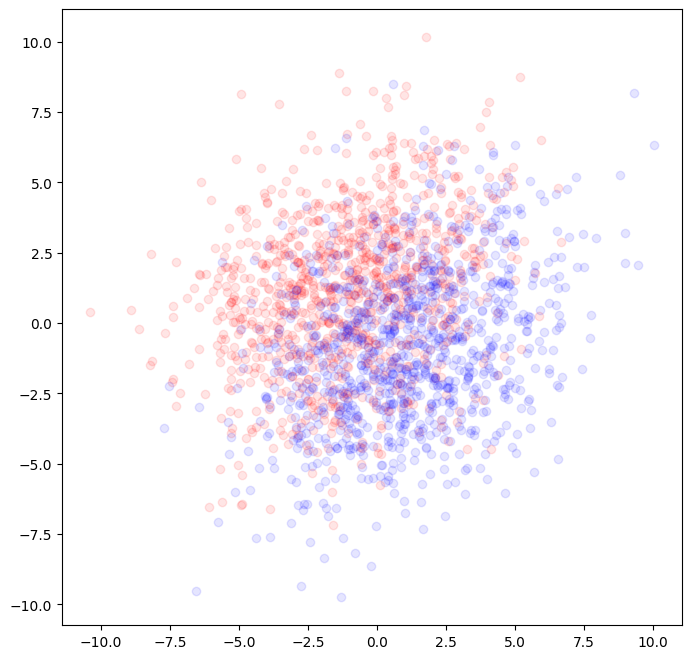

In [67]:
#pts
f, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(pts_1[:,0], pts_1[:,1], c='r',  alpha = 0.1)
ax.scatter(pts_2[:,0], pts_2[:,1], c='b',  alpha = 0.1)


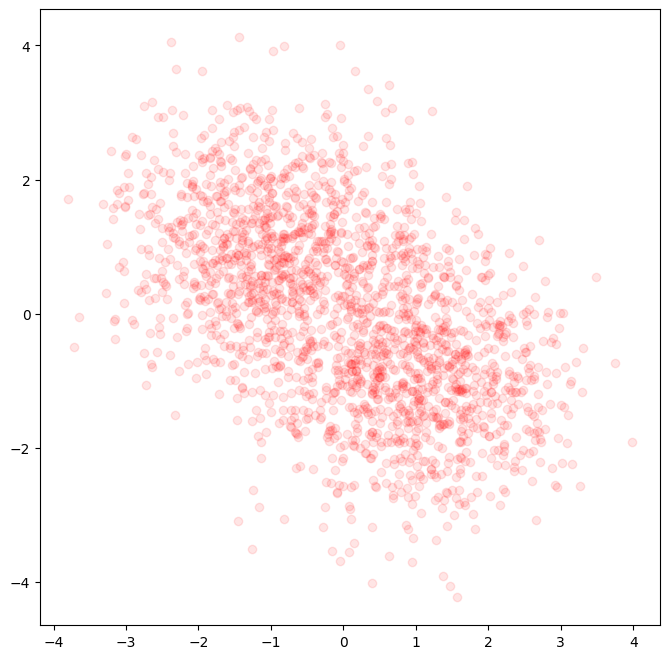

In [30]:
all_x = np.vstack((pts_1, pts_2))
all_x.shape

f, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(all_x[:,0], all_x[:,1], c='r',  alpha = 0.1)


In [56]:
y_1 = np.zeros(1000)
y_2 = np.ones(1000)
y = np.concatenate([y_1, y_2])

In [58]:
index = np.random.permutation(all_x.shape[0])

In [59]:
x_new = all_x[index]

In [63]:
index[1]

680

In [61]:
x_new[0:2,]

array([[ 1.29992148, -0.58503075],
       [-0.88943372,  0.29124717]])

In [64]:
all_x[680,:]

array([-0.88943372,  0.29124717])

### Imitate Paper Figure

In [73]:
def rec_dd():
    return defaultdict(rec_dd)
import seaborn as sns 
import pickle
from collections import defaultdict
from sklearn.datasets import make_moons


C1 = sns.xkcd_rgb["green"]
C2 = sns.xkcd_rgb["orange"]
C3 = sns.xkcd_rgb["blue"]
C4 = sns.xkcd_rgb["red"]
COLS = np.array([C1, C2, C3, C4])
UC1 = sns.xkcd_rgb["green"]
UC2 = sns.xkcd_rgb["orange"]
UC3 = sns.xkcd_rgb["blue"]
UC4 = sns.xkcd_rgb["red"]
UCOLS = np.array([UC1, UC2, UC3, UC4])
EXTENT = (-3, 4, -2, 3)
dnm = 'halfmoon'
coreset_sizes=10

In [74]:
def predictive_entropy(g):
    p = g[0,...]
    return -p*np.log(p) - (1-p)*np.log(1-p)
N = 1000
(X, Y) = make_moons(n_samples=N, noise=0.1, random_state=42)

X, Y = torch.from_numpy(X.astype(np.float32)), torch.from_numpy(
                Y[...,None].astype(np.float32)
            )


/tmp/ipykernel_338/2591497172.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ax.scatter(us[:, 0], us[:, 1], c=UCOLS[torch.tensor(zs[idx]).squeeze().int().numpy()], alpha=a1, marker='x', s=vs[idx])
/tmp/ipykernel_338/3124628095.py:3: RuntimeWarning: divide by zero encountered in log
  return -p*np.log(p) - (1-p)*np.log(1-p)
/tmp/ipykernel_338/3124628095.py:3: RuntimeWarning: invalid value encountered in multiply
  return -p*np.log(p) - (1-p)*np.log(1-p)


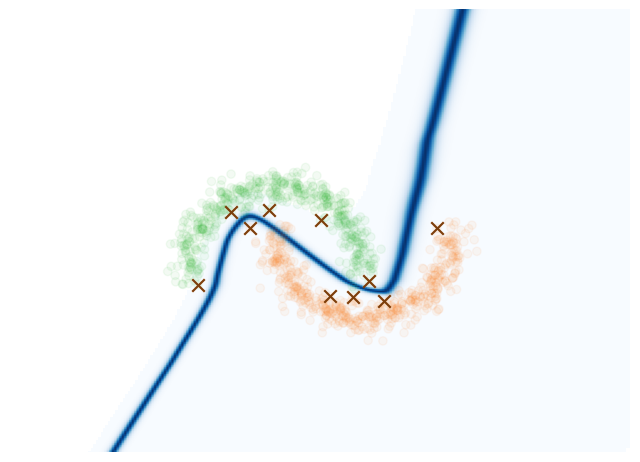

In [77]:
meth = 'mfvi_selection'
with open('/home/studio-lab-user/all_data/vi_result/results.pk', 'rb') as f:
       results = pickle.load(f)
us, zs, vs, gpreds = (
        results[dnm][meth][coreset_sizes][0]['us'],
        results[dnm][meth][coreset_sizes][0]['zs'],
        results[dnm][meth][coreset_sizes][0]['vs'],
        results[dnm][meth][coreset_sizes][0]['grid_preds'],
)

def plot_full(idx=-1, a0=0.05, a1=0.9, ax=None, fnm=None):
    if ax is None:
        f, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.scatter(X[:, 0], X[:, 1], c=COLS[Y.squeeze().int().numpy()], alpha=a0)
    ax.scatter(us[:, 0], us[:, 1], c=UCOLS[torch.tensor(zs[idx]).squeeze().int().numpy()], alpha=a1, marker='x', s=vs[idx])
    ax.scatter(us[:, 0], us[:, 1], c='k', alpha=0.5, marker='x', s=vs[idx])
    ents = predictive_entropy(gpreds[idx]).reshape((250, 250)).T
    ax.imshow(ents, extent=EXTENT, origin="lower", cmap='Blues')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.axis('off')
    plt.show()

plot_full(idx=-1, fnm='figs/mcmc-vi-coreset')

In [66]:
us

defaultdict(<function __main__.rec_dd()>, {})